In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d

from MITRotor import BEM, IEA10MW, BEMGeometry, NoTipLoss, KraghAerodynamics, Madsen_Annulus_Momentum, NoTangentialInduction

In [11]:
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [12]:
def extract_columns(file_list,keys):
    data_dict = {}

    i = 0
    
    for file in file_list:
        with open(file, 'r') as f:
            lines = f.readlines()
            
            # Skip the header line and extract columns 1, 4, and 5
            data = np.loadtxt(lines[1:])[:, [0, 3, 4]]
            data_dict[keys[i]] = data

            i = i + 1
    

    return data_dict

In [13]:
casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']
# casenames = [r's0_v0']

file_list = []
for count in range(len(casenames)):
    file_list.append('/scratch/09909/smata/wrf_les_sweep/runs/10MW/gad_sweep/'+casenames[count]+'/input_sounding')

data = extract_columns(file_list,casenames)

In [14]:
nElements = 26
nSections = 158

In [15]:
rotor = IEA10MW()

bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=nElements, Ntheta=nSections), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=Madsen_Annulus_Momentum(), tangential_induction_model=NoTangentialInduction())

pitch, tsr, yaw = np.deg2rad(0), 10.634, np.deg2rad(0.0)
sol = bem(pitch, tsr, yaw)

In [16]:
z = sol.geom.mu_mesh * rotor.R * np.cos(sol.geom.theta_mesh) + 378

/tmp/ipykernel_350301/2582195331.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[xs[count],ys[count]].scatter(sol.a('annulus'), sol.Ct('annulus'), cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=1,zorder=3)
/tmp/ipykernel_350301/2582195331.py:54: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[4,4].scatter(sol.a('annulus'), sol.Ct('annulus'), cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=1)


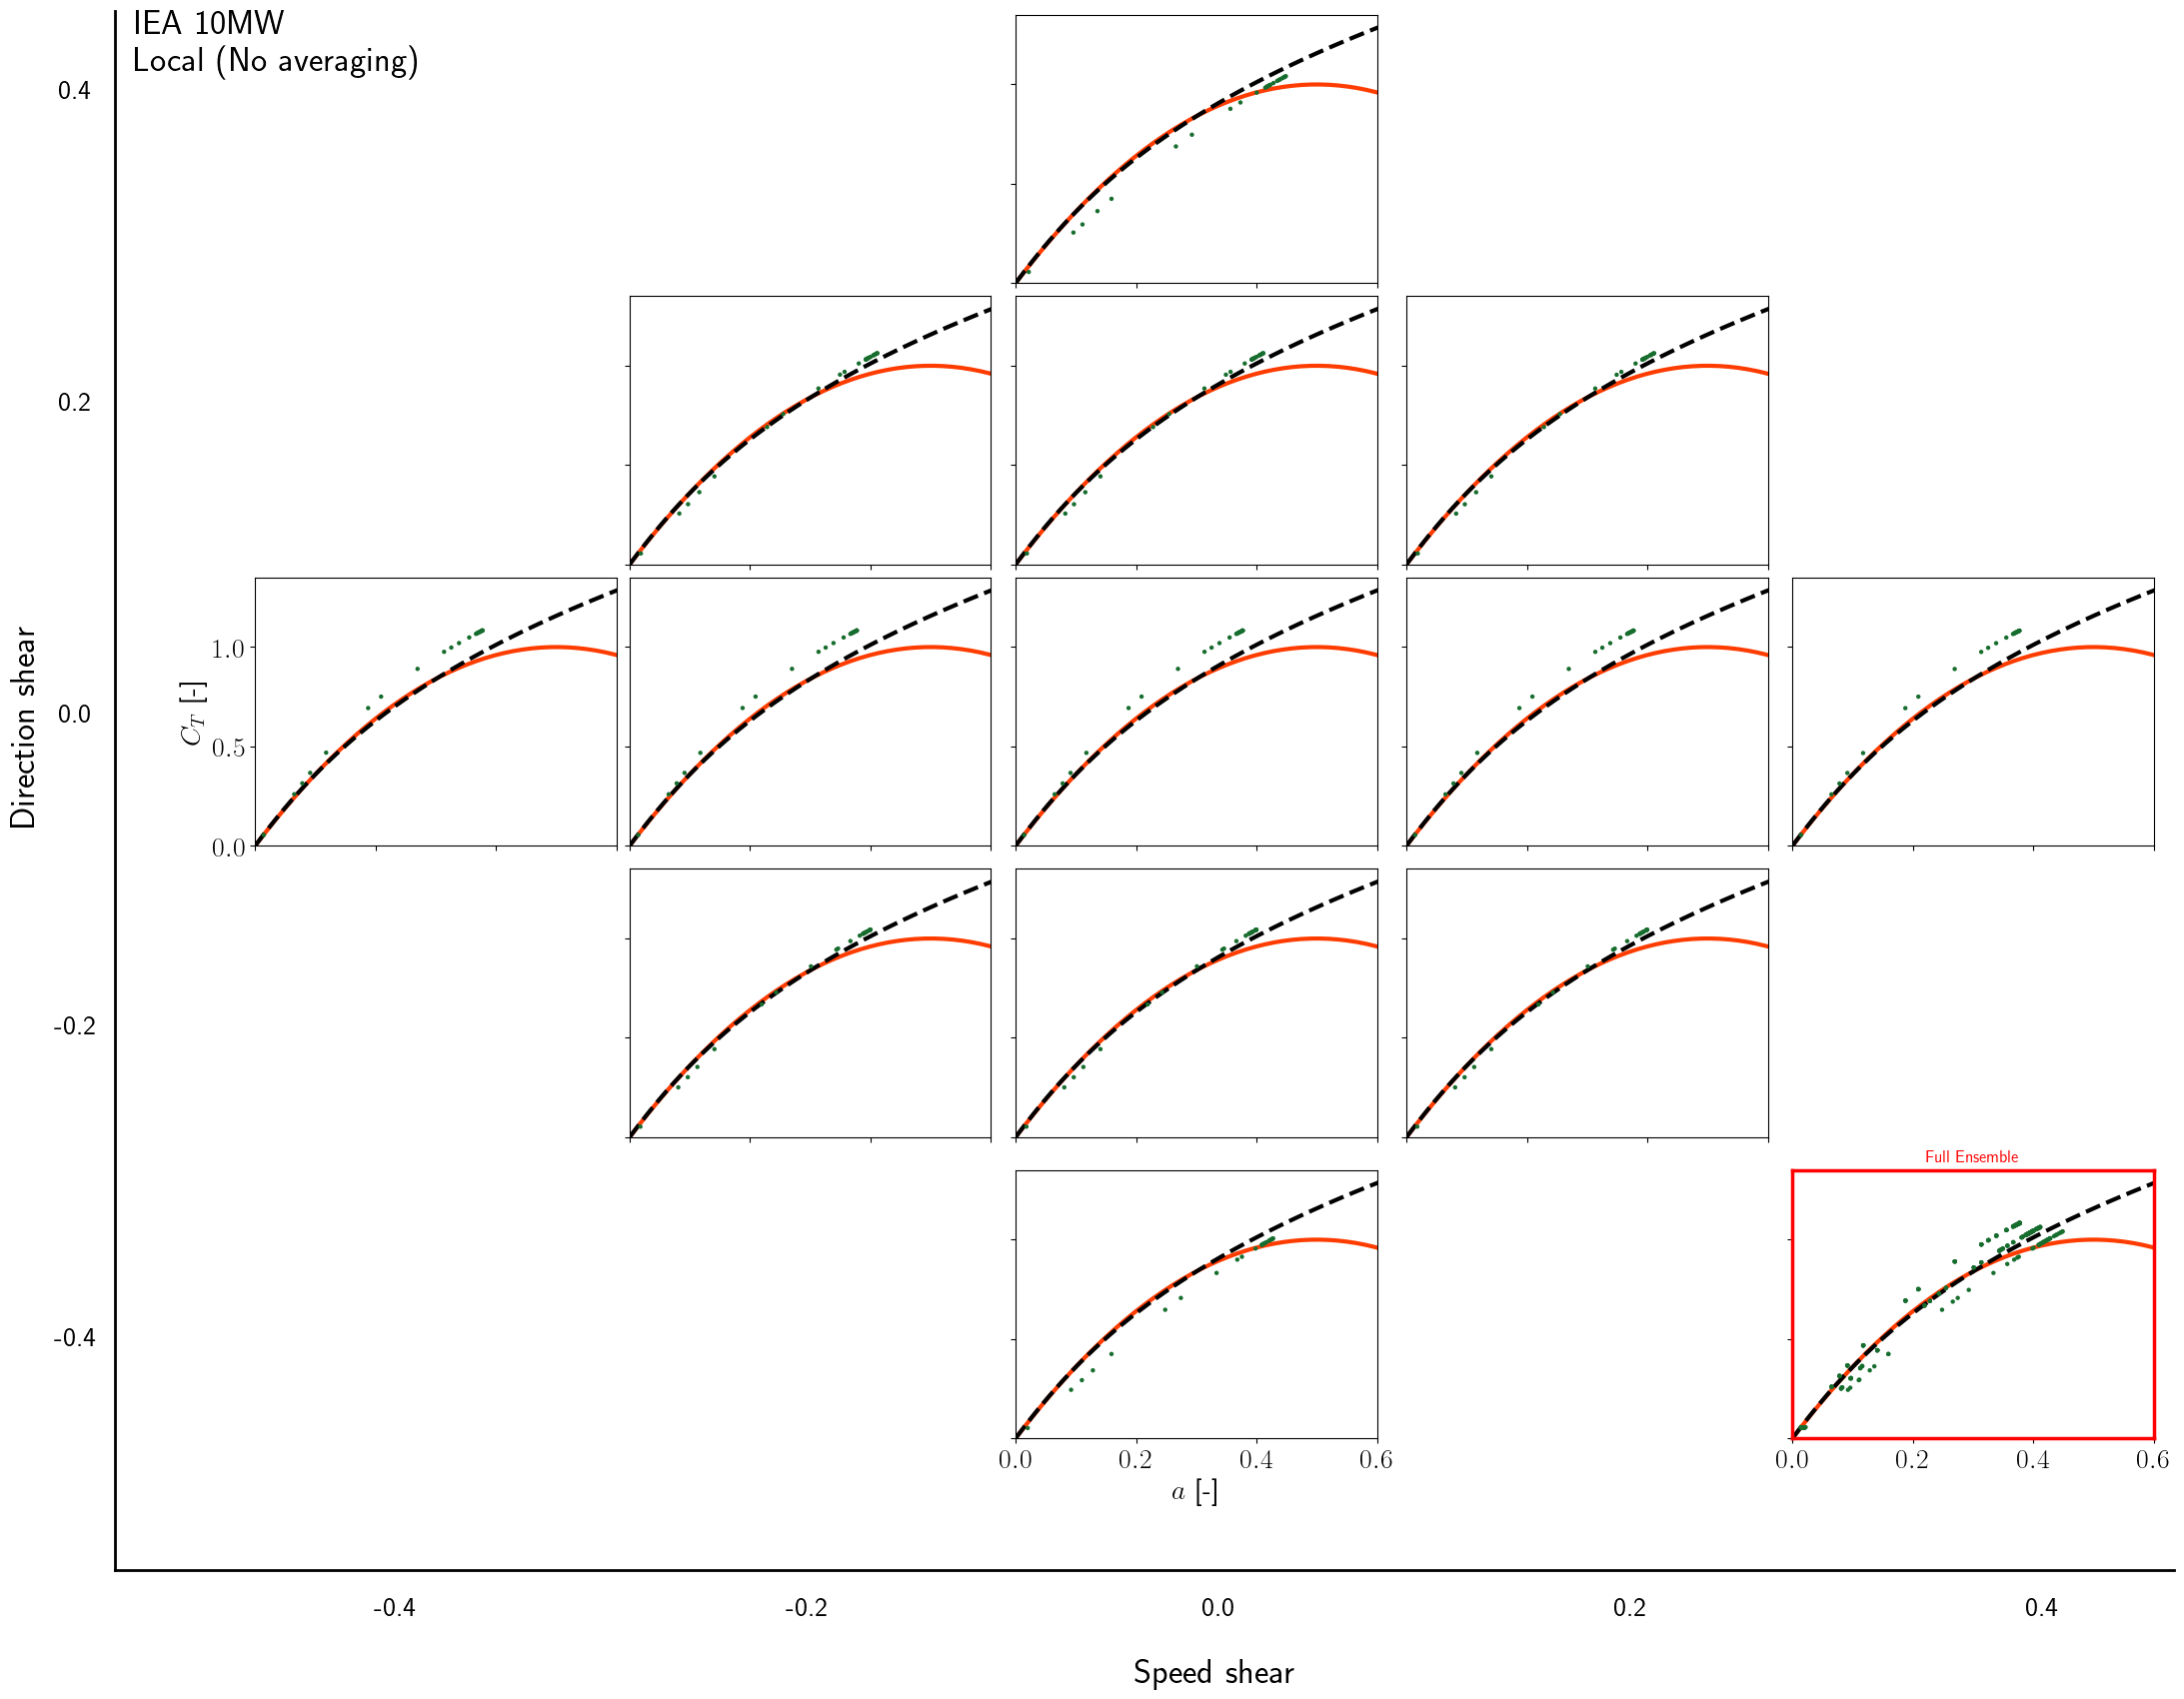

In [17]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

shear = [0,-2,0,2,-4,-2,0,2,4,-2,0,2,0]
veer  = [4,2,2,2,0,0,0,0,0,-2,-2,-2,-4]

power     = np.zeros_like(xs, dtype='float')
thrust    = np.zeros_like(xs, dtype='float')
induction = np.zeros_like(xs, dtype='float')

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), constrained_layout=True,sharex=True, sharey=True)

for count in range(len(casenames)):
    u_func = interp1d(data[casenames[count]][:,0],data[casenames[count]][:,1])
    v_func = interp1d(data[casenames[count]][:,0],data[casenames[count]][:,2])

    u = u_func(z)
    v = v_func(z)

    wdir = np.atan2(v,u)

    U = (u**2 + v**2)**(1/2)

    # U = u / 7

    bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=nElements, Ntheta=nSections), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=Madsen_Annulus_Momentum(veer=veer[count]), tangential_induction_model=NoTangentialInduction())
    sol = bem(pitch, tsr, yaw, v_inf = 7, U = U/7, wdir = wdir)
    # sol = bem(pitch, tsr, yaw, U = U)
    # sol = bem(pitch, tsr, yaw, U = U)

    power[count] = sol.power()
    thrust[count] = sol.thrust()
    induction[count] = sol.a()

    a_mom = np.linspace(0,0.75,50)
    ct_mom = 4 * a_mom * (1 - a_mom)
    ax[xs[count],ys[count]].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1)

    ct_mad = np.linspace(0,1.5,75)
    k1 = 0.2460
    k2 = 0.0586
    k3 = 0.0883
    a_mad = k3 * ct_mad**3 + k2 * ct_mad**2 + k1 * ct_mad
    ax[xs[count],ys[count]].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2)

    mesh = ax[xs[count],ys[count]].scatter(sol.a('annulus'), sol.Ct('annulus'), cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=1,zorder=3)

    # ax[xs[count],ys[count]].scatter(sol.a(), sol.Ct(), cmap='viridis', s=10, edgecolor='none',color='#ffc300',zorder=4)

    # ax[xs[count],ys[count]].set_aspect('equal')
    ax[xs[count],ys[count]].set_xlim([0,0.6])
    ax[xs[count],ys[count]].set_ylim([0,1.35])

    ax[4,4].scatter(sol.a('annulus'), sol.Ct('annulus'), cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=1)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
# ax[4,4].axis('off')
for spine in ax[4,4].spines.values():
    spine.set_linewidth(2.5)
    spine.set_edgecolor('red')

ax[4,4].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1)
ax[4,4].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2)
ax[4,4].set_title('Full Ensemble', fontweight='bold',color='r')

ax[2,0].set_ylabel('$C_T$ [-]', fontsize=20)
ax[4,2].set_xlabel('$a$ [-]', fontsize=20)
# Add a single colorbar on the right-hand side
# cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
# cbar.set_label('Deviation in axial force from uniform [\%]',fontsize=25)

# Add the number line below the subplots
line_y = -0.04  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.03, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.14  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.52, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)

line_x = -0.03  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.04, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.15  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.01,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.46, 'Direction shear', ha='center', fontsize=25,rotation=90)
fig.text(-0.02,0.985, 'IEA 10MW', ha='left', fontsize=25,rotation=0)
fig.text(-0.02,0.96, 'Local (No averaging)', ha='left', fontsize=25,rotation=0)

# plt.savefig(f"./figs/wrf_10MW_local.png", bbox_inches="tight", dpi=600)
plt.show()


In [18]:
power = 100 * (power - power[6]) / power[6]
thrust = 100 * (thrust - thrust[6]) / thrust[6]
induction = 100 * (induction - induction[6]) / induction[6]

/tmp/ipykernel_350301/4020436384.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  pow_levels = plt.cm.get_cmap('seismic', n_levels)  # Extract 13 colors from 'viridis'
/tmp/ipykernel_350301/4020436384.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  thr_levels = plt.cm.get_cmap('PiYG', n_levels)  # Extract 13 colors from 'viridis'
/tmp/ipykernel_350301/4020436384.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ind_levels = plt.cm.get_cmap('Spectral', 

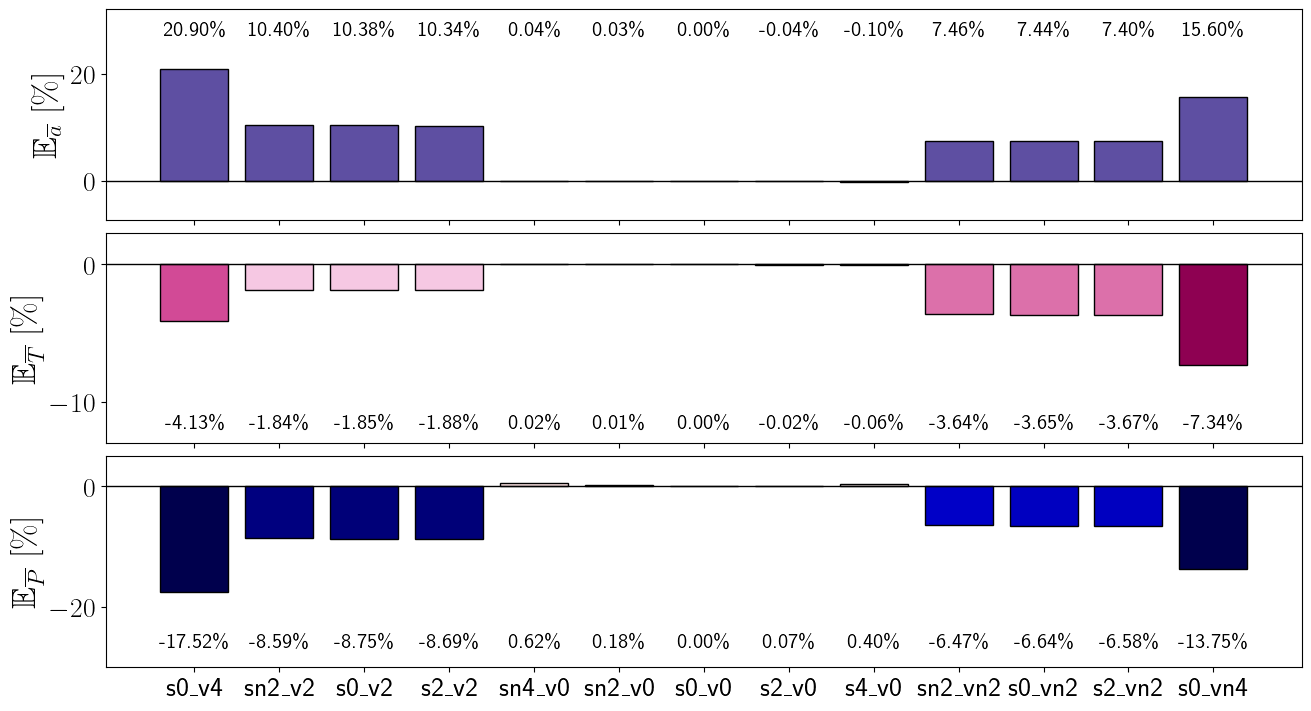

In [19]:
n_levels = 100

pow_levels = plt.cm.get_cmap('seismic', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-10, vmax=10)  # Normalize power to [0, 1]
pow_cmap = [pow_levels(int(norm(p) * (n_levels - 1))) for p in power]  # Map power to discrete colors

thr_levels = plt.cm.get_cmap('PiYG', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-6, vmax=6)  # Normalize power to [0, 1]
thr_cmap = [thr_levels(int(norm(t) * (n_levels - 1))) for t in thrust]  # Map power to discrete colors

ind_levels = plt.cm.get_cmap('Spectral', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-7, vmax=7)  # Normalize power to [0, 1]
ind_cmap = [ind_levels(int(norm(a) * (n_levels - 1))) for a in induction]  # Map power to discrete colors


width = 0.75
alpha = 1.0

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(13, 7), sharex=True, constrained_layout = True)
ax[0].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[1].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[2].axhline(0, color='black', linestyle='solid', linewidth=1)
# ax[3].axhline(0, color='black', linestyle='solid', linewidth=1)

ind = np.arange(len(casenames))

for count in range(len(casenames)):

    # induction
    ax[0].bar(ind[count], induction[count], color=ind_cmap[count], edgecolor='black', alpha=alpha)
    ax[0].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{a}}~[\%]$', fontsize=fontsize)
    ax[0].text(ind[count], 27, f'{induction[count]:0.2f}\%', ha='center', fontsize=15)
    # ax[0].set_ylim([-4.5,18])
    ax[0].set_ylim([-7.2,32])

    # thrust
    ax[1].bar(ind[count], thrust[count], color=thr_cmap[count], edgecolor='black', alpha=alpha)
    ax[1].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{T}}~[\%]$', fontsize=fontsize)
    # ax[1].text(ind[count], -4.75, f'{thrust[count]}\%', ha='center', fontsize=15)
    # ax[1].set_ylim([-5,1.5])
    ax[1].text(ind[count], -12, f'{thrust[count]:0.2f}\%', ha='center', fontsize=15)
    ax[1].set_ylim([-13,2.3])

    # # torque
    # ax[2].bar(ind[count], wrfles_rel_diff_torque, color=colors[count], edgecolor='black', alpha=alpha)
    # ax[2].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{Q}}~[\%]$', fontsize=fontsize)
    # ax[2].text(ind[count], -8, f'{wrfles_rel_diff_torque[0]}\%', ha='center', fontsize=15)

    # power
    ax[2].bar(ind[count], power[count], color=pow_cmap[count], edgecolor='black', alpha=alpha)
    ax[2].set_xticks(ind)
    ax[2].set_xticklabels(casenames)
    ax[2].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{P}}~[\%]$', fontsize=fontsize)
    ax[2].text(ind[count], -27, f'{power[count]:0.2f}\%', ha='center', fontsize=15)
    # ax[2].set_ylim([-14,4])
    ax[2].set_ylim([-30,5])